## Importazione e preprocessing

### Importazione pacchetti

In [28]:
#Stile di visualizzazione plot fatti con matplotlib
%matplotlib inline

#Base
import os
import pandas as pd
import numpy as np
import scipy as sp
import time
import sys

#Visualizzazione
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sn  #Per heatmap

#Preprocessing e altro
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, ParameterGrid, KFold
sys.path.insert(1, '../Data')
from preprocessing import preprocessing_diabetes
from preprocessing_v2 import preprocessing_diabetes_v2
from preprocessing_v3 import preprocessing_diabetes_v3
from imblearn.over_sampling import SMOTE

#Modelli
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC as SupportVectorMachineClassifier
from sklearn.neural_network import MLPClassifier

#Metriche
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, make_scorer

In [29]:
import warnings
warnings.filterwarnings(action='ignore')

### Importazione dati e diversi pre-processing

In [30]:
trainingData = pd.read_csv('../Data/diabetes_train.csv')
testData = pd.read_csv('../Data/diabetes_test.csv')

In [31]:
df_train_scal, df_test_scal, y_train, y_test = preprocessing_diabetes_v3(trainingData, testData)
df_train_noFeat, df_test_noFeat, _, _ = preprocessing_diabetes_v3(trainingData, testData, option='Delete')
df_train_PCA, df_test_PCA, _, _ = preprocessing_diabetes_v3(trainingData, testData, option='PCA')
df_train_noSmok, df_test_noSmok, _, _ = preprocessing_diabetes_v3(trainingData, testData, delete_smoking=True)
#With oversampling
df_train_scal_os, df_test_scal_os, y_train_os, y_test_os = preprocessing_diabetes_v3(trainingData, testData, oversample=True)
df_train_noFeat_os, df_test_noFeat_os, _, _ = preprocessing_diabetes_v3(trainingData, testData, option='Delete', oversample=True)
df_train_PCA_os, df_test_PCA_os, _, _ = preprocessing_diabetes_v3(trainingData, testData, option='PCA', oversample=True)
df_train_noSmok_os, df_test_noSmok_os, _, _ = preprocessing_diabetes_v3(trainingData, testData, delete_smoking=True, oversample=True)
#With oversampling and feature augmentation
df_train_scal_os_fa, df_test_scal_os_fa, y_train_os_fa, y_test_os_fa = preprocessing_diabetes_v3(trainingData, testData, augment=True, oversample=True)
df_train_noFeat_os_fa, df_test_noFeat_os_fa, _, _ = preprocessing_diabetes_v3(trainingData, testData, option='Delete', augment=True, oversample=True)
df_train_PCA_os_fa, df_test_PCA_os_fa, _, _ = preprocessing_diabetes_v3(trainingData, testData, option='PCA', augment=True, oversample=True)
df_train_noSmok_os_fa, df_test_noSmok_os_fa, _, _ = preprocessing_diabetes_v3(trainingData, testData, delete_smoking=True, augment=True, oversample=True)

In [32]:
display(df_train_scal)

,age,bmi,HbA1c_level,blood_glucose_level,Insulin_Sensitivity_Est,BMI_Glucose_Interaction,Random_Lab_Marker,gender,hypertension,heart_disease,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0.894928,-0.176195,0.503722,0.095442,0.476212,-0.055814,-1.175480,1,0,0,False,False,False,True,False
1,0.668110,0.758421,1.541394,-0.072366,0.007480,0.266092,-1.007407,1,1,0,False,False,False,True,False
2,1.034925,0.365698,2.218108,1.701715,0.481892,1.438787,0.651317,1,0,0,False,False,True,False,False
3,0.579111,0.667063,2.104176,0.043478,0.716419,0.317432,-0.953973,1,0,0,False,False,False,True,False
4,1.146937,1.446470,0.321064,0.328064,-0.132528,0.907586,0.423327,1,0,0,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,-1.205383,0.064420,-0.402472,0.164156,0.179832,0.206146,0.311464,0,0,0,False,False,True,False,False
582,1.134089,-0.535417,-1.650545,0.127452,-2.138018,-0.213306,-0.655270,0,0,0,False,False,False,False,True
583,0.672161,0.122466,-0.008653,-0.142200,-1.439506,-0.080177,0.943590,1,0,1,True,False,False,False,False
584,-0.852201,-0.142217,0.134120,0.917149,0.000000,0.521425,1.180482,0,0,0,False,False,False,False,False


## Histogram-based Gradient Boosting Classification Tree

In [33]:
random_seed = 42

In [34]:
# Creazione di una sottomappa di viridis, in modo da avere il verde come massimo
viridis = matplotlib.colormaps['viridis'].resampled(280)
newcolors = viridis(np.linspace(0, 1, 280))[:210]
newcmp=matplotlib.colors.ListedColormap(newcolors)

In [35]:
#Funzione per rappresentare la tabella delle performance sul test
def performances(model,data,y_true,title=None):
    start=time.time()
    y_pred=model.predict(data)
    stop=time.time()
    totalTime=stop-start
    acc = model.score(data, y_true)
    prec = precision_score(y_true, y_pred, average='binary')
    rec = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    df = pd.DataFrame({'Accuracy': [acc], 
                        'Precision': [prec ], 
                        'Recall': [rec ],
                        'F1': [f1 ]
                       },
                      index=[title])
    cmat=pd.DataFrame(confusion_matrix(y_true,y_pred,labels=model.classes_))
    return df,cmat,totalTime

In [36]:
# Funzione per mostrare la confusion matrix
def heatMapConstr(heatMapMatrices, titles):
    fig,axs=plt.subplots(1,len(titles),figsize=(18,3))
    for i in range(len(titles)):
        normMatrix=heatMapMatrices[i].div(heatMapMatrices[i].sum(axis=1), axis=0)
        ax=axs[i]
        im=ax.imshow(normMatrix,vmin=0,vmax=1,cmap=newcmp)
        ax.set_yticks(range(len(heatMapMatrices[i].index)))
        ax.set_yticklabels(heatMapMatrices[i].index)
        ax.set_xticks(range(len(heatMapMatrices[i].columns)))
        ax.set_xticklabels(heatMapMatrices[i].columns)
        ax.title.set_text(titles[i])
        ax.set_xlabel("predicted")
        ax.set_ylabel("true")
        for a in range(len(heatMapMatrices[i].index)):
            for j in range(len(heatMapMatrices[i].columns)):
                text = ax.text(j, a, heatMapMatrices[i].iloc[a, j], ha="center", va="center", color='w')
    #plt.savefig('Confusion_matrices_hgb_ig',dpi=300)
    fig.tight_layout()
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    #plt.savefig('gs_SVM_'+scoreInterest,dpi=300)
    plt.show()

In [37]:
#Funzione per mostrare la heat map della grid search
def heatMapGridSearch(modelResults, gridDict, scoreInterest):  # mean_test_score, mean_train_score, mean_fit_time
    vmin=modelResults[scoreInterest].min()
    vmax=1
    if scoreInterest=='time':
        vmax=modelResults[scoreInterest].max()

    fig,axs=plt.subplots(1,len(gridDict['max_iter']),figsize=(15,4))
    for i,bs in enumerate(gridDict['max_iter']):
        square=pd.DataFrame()
        for act in gridDict['min_samples_leaf']:
            col=pd.DataFrame()
            for alp in gridDict['max_leaf_nodes']:
                df = modelResults[modelResults['param_max_iter']==bs][modelResults['param_min_samples_leaf']==act][modelResults['param_max_leaf_nodes']==alp]
                df=df.pivot(index='param_learning_rate', columns='param_max_depth', values=scoreInterest)
                col=pd.concat([col,df])
            square=pd.concat([square,col], axis=1)

        ax=axs[i]
        im=ax.imshow(square.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
        ax.set_yticks(range(len(square.index)))
        ax.set_yticklabels(square.index)
        ax.set_xticks(range(len(square.columns)))
        ax.set_xticklabels(square.columns)
        #ax.title.set_text(bs)
        ax.set_xlabel("max depth")
        ax.set_ylabel("learning rate")
        for a in range(len(square.index)):
            for j in range(len(square.columns)):
                c="w"
                if square.iloc[a, j]==modelResults[scoreInterest].max():
                    c="red"
                elif square.iloc[a, j]==square.values.max():
                    c="gold"
                text = ax.text(j, a, "{0:.2f}".format(square.iloc[a, j]),
                            ha="center", va="center", color=c)
        #Linee verticali e orizzontali di separazione
        ax.axhline(y=3.5,c="black",linewidth=0.75,zorder=0)
        ax.axvline(x=4.5,c="black",linewidth=0.75,zorder=0)
        ax.axvline(x=9.5,c="black",linewidth=0.75,zorder=0)
        #Testi aggiuntivi degli assi mancanti e titolo
        ax.text(7, -2, 'Max iter = '+str(bs), ha="center", va="center", fontsize=12)
        ax.text(7, -1.25, 'min samples per leaf', ha="center", va="center")
        ax.text(15.25, 3.5, 'max leaf nodes', ha="center", va="center", rotation='vertical')
        ax.text(2, -0.75, gridDict['min_samples_leaf'][0], ha="center", va="center")
        ax.text(7, -0.75, gridDict['min_samples_leaf'][1], ha="center", va="center")
        ax.text(12, -0.75, gridDict['min_samples_leaf'][2], ha="center", va="center")
        ax.text(14.75, 1.5, gridDict['max_leaf_nodes'][0], ha="left", va="center")
        ax.text(14.75, 5.5, gridDict['max_leaf_nodes'][1], ha="left", va="center")

    cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    #plt.savefig('hgb_'+scoreInterest,dpi=300)
    plt.show()
    print('MIGLIORI IPERPARAMETRI')
    max_elem_row=modelResults[scoreInterest].astype(float).idxmax()
    bestModel = modelResults.iloc[max_elem_row]
    bestModelShort = bestModel[[idx for idx in bestModel.index if 'param' in idx and 'params' not in idx]+['mean_train_score','mean_test_score','mean_fit_time']]
    display(pd.DataFrame(bestModelShort).transpose())
    return bestModel

### Grid Search e train

In [38]:
#Definizione degli iperparametri e della griglia
GRID = {
    'learning_rate': [0.2, 0.5, 0.8, 1],
    'max_iter': [50,100],
    'max_leaf_nodes': [10, 31],
    'min_samples_leaf': [10, 20, 25],
    'max_depth': [3, 5, 8, 10, None]
}

#### Classico

In [39]:
#Dichiarazione della svm
hgb1 = HistGradientBoostingClassifier(random_state=random_seed)

#Dichiarazione delle GridSearch
hgb1_gs = GridSearchCV(estimator=hgb1,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
hgb1_gs.fit(df_train_scal, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1 = pd.DataFrame(hgb1_gs.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


In [40]:
display(results1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,params,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.047992,0.005893,0.006646,0.001669,0.2,3,50,10,10,"{'learning_rate': 0.2, 'max_depth': 3, 'max_it...",...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000
1,0.049483,0.004373,0.007320,0.001641,0.2,3,50,10,20,"{'learning_rate': 0.2, 'max_depth': 3, 'max_it...",...,0.996047,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999605,0.001186
2,0.036927,0.004798,0.005377,0.000614,0.2,3,50,10,25,"{'learning_rate': 0.2, 'max_depth': 3, 'max_it...",...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000
3,0.041808,0.005961,0.005074,0.000531,0.2,3,50,31,10,"{'learning_rate': 0.2, 'max_depth': 3, 'max_it...",...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000
4,0.039753,0.005875,0.005262,0.000759,0.2,3,50,31,20,"{'learning_rate': 0.2, 'max_depth': 3, 'max_it...",...,0.996047,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999605,0.001186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.059363,0.028288,0.005040,0.001691,1.0,None,100,10,20,"{'learning_rate': 1, 'max_depth': None, 'max_i...",...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000
236,0.057255,0.030032,0.004504,0.001521,1.0,None,100,10,25,"{'learning_rate': 1, 'max_depth': None, 'max_i...",...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000
237,0.081032,0.032077,0.004006,0.001155,1.0,None,100,31,10,"{'learning_rate': 1, 'max_depth': None, 'max_i...",...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000
238,0.046021,0.022374,0.003652,0.000941,1.0,None,100,31,20,"{'learning_rate': 1, 'max_depth': None, 'max_i...",...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000


#### No correlation

In [41]:
#Dichiarazione della svm
hgb1_noFeat = HistGradientBoostingClassifier(random_state=random_seed)

#Dichiarazione delle GridSearch
hgb1_noFeat_gs = GridSearchCV(estimator=hgb1_noFeat,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
hgb1_noFeat_gs.fit(df_train_noFeat, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noFeat = pd.DataFrame(hgb1_noFeat_gs.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


#### No smoking

In [42]:
#Dichiarazione della svm
hgb1_noSmok = HistGradientBoostingClassifier(random_state=random_seed)

#Dichiarazione delle GridSearch
hgb1_noSmok_gs = GridSearchCV(estimator=hgb1_noSmok,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
hgb1_noSmok_gs.fit(df_train_noSmok, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noSmok = pd.DataFrame(hgb1_noSmok_gs.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


#### PCA

In [43]:
#Dichiarazione della svm
hgb1_PCA = HistGradientBoostingClassifier(random_state=random_seed)

#Dichiarazione delle GridSearch
hgb1_PCA_gs = GridSearchCV(estimator=hgb1_PCA,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
hgb1_PCA_gs.fit(df_train_PCA, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_PCA = pd.DataFrame(hgb1_PCA_gs.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


#### Classico - Oversampling

In [44]:
#Dichiarazione della svm
hgb1_os = HistGradientBoostingClassifier(random_state=random_seed)

#Dichiarazione delle GridSearch
hgb1_gs_os = GridSearchCV(estimator=hgb1_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
hgb1_gs_os.fit(df_train_scal_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_os = pd.DataFrame(hgb1_gs_os.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


In [45]:
display(results1_os)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,params,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.073620,0.016824,0.007341,0.001629,0.2,3,50,10,10,"{'learning_rate': 0.2, 'max_depth': 3, 'max_it...",...,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,0.998752,0.999748,0.000504
1,0.072028,0.016063,0.008692,0.001997,0.2,3,50,10,20,"{'learning_rate': 0.2, 'max_depth': 3, 'max_it...",...,1.0,0.998742,1.0,1.0,1.0,0.998723,1.0,0.998752,0.999622,0.000578
2,0.065897,0.012137,0.009190,0.003627,0.2,3,50,10,25,"{'learning_rate': 0.2, 'max_depth': 3, 'max_it...",...,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,0.998752,0.999875,0.000375
3,0.082436,0.014934,0.008385,0.001789,0.2,3,50,31,10,"{'learning_rate': 0.2, 'max_depth': 3, 'max_it...",...,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,0.998752,0.999748,0.000504
4,0.080255,0.015530,0.009073,0.004484,0.2,3,50,31,20,"{'learning_rate': 0.2, 'max_depth': 3, 'max_it...",...,1.0,0.998742,1.0,1.0,1.0,0.998723,1.0,0.998752,0.999622,0.000578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.137765,0.054158,0.013753,0.020185,1.0,None,100,10,20,"{'learning_rate': 1, 'max_depth': None, 'max_i...",...,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,0.000000
236,0.106320,0.046625,0.008186,0.004567,1.0,None,100,10,25,"{'learning_rate': 1, 'max_depth': None, 'max_i...",...,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,0.000000
237,0.110672,0.048761,0.007016,0.003200,1.0,None,100,31,10,"{'learning_rate': 1, 'max_depth': None, 'max_i...",...,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,0.000000
238,0.106073,0.049410,0.006648,0.002817,1.0,None,100,31,20,"{'learning_rate': 1, 'max_depth': None, 'max_i...",...,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,0.000000


#### No correlation - Oversampling

In [46]:
#Dichiarazione della svm
hgb1_noFeat_os = HistGradientBoostingClassifier(random_state=random_seed)

#Dichiarazione delle GridSearch
hgb1_noFeat_gs_os = GridSearchCV(estimator=hgb1_noFeat_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
hgb1_noFeat_gs_os.fit(df_train_noFeat_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noFeat_os = pd.DataFrame(hgb1_noFeat_gs_os.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


#### No smoking - Oversampling

In [47]:
#Dichiarazione della svm
hgb1_noSmok_os = HistGradientBoostingClassifier(random_state=random_seed)

#Dichiarazione delle GridSearch
hgb1_noSmok_gs_os = GridSearchCV(estimator=hgb1_noSmok_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
hgb1_noSmok_gs_os.fit(df_train_noSmok_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noSmok_os = pd.DataFrame(hgb1_noSmok_gs_os.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


#### PCA - Oversampling

In [48]:
#Dichiarazione della svm
hgb1_PCA_os = HistGradientBoostingClassifier(random_state=random_seed)

#Dichiarazione delle GridSearch
hgb1_PCA_gs_os = GridSearchCV(estimator=hgb1_PCA_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
hgb1_PCA_gs_os.fit(df_train_PCA_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_PCA_os = pd.DataFrame(hgb1_PCA_gs_os.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


### Visualizzazione

Colonne del DataFrame

In [49]:
results1.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_learning_rate', 'param_max_depth', 'param_max_iter',
       'param_max_leaf_nodes', 'param_min_samples_leaf', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'split5_train_score', 'split6_train_score', 'split7_train_score',
       'split8_train_score', 'split9_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

Stampa delle heat map delle grid search

CLASSICO


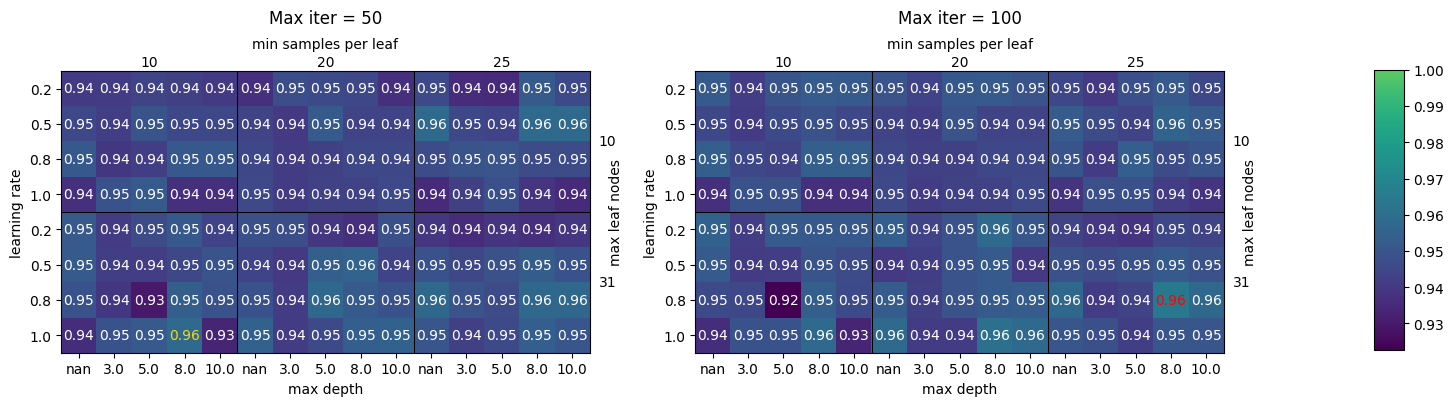

MIGLIORI IPERPARAMETRI


,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
155,0.8,8,100,31,25,1.0,0.964497,0.064288


NO CORRELATED FEATURE


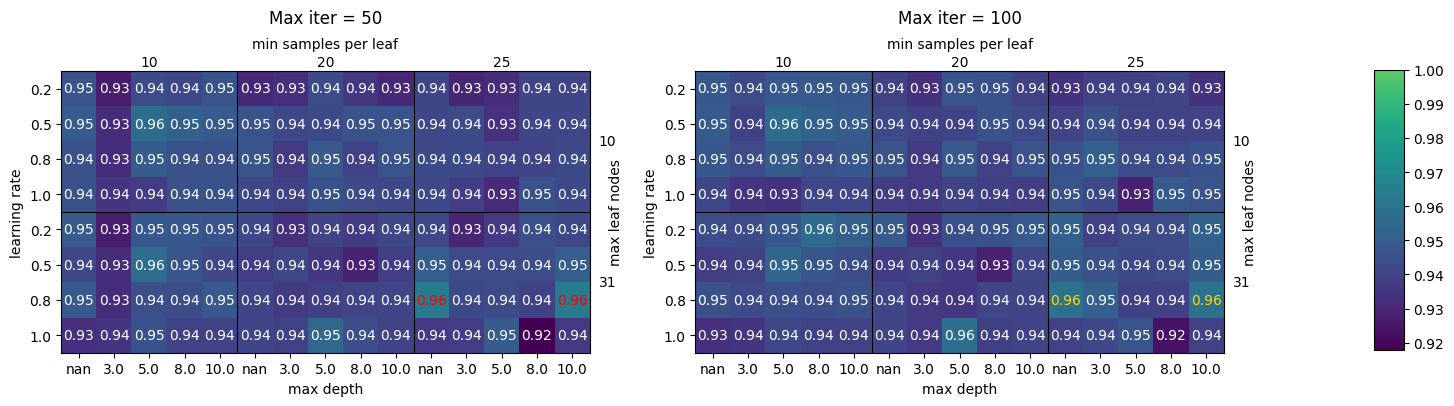

MIGLIORI IPERPARAMETRI


,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
161,0.8,10,50,31,25,1.0,0.963599,0.073591


NO SMOKING


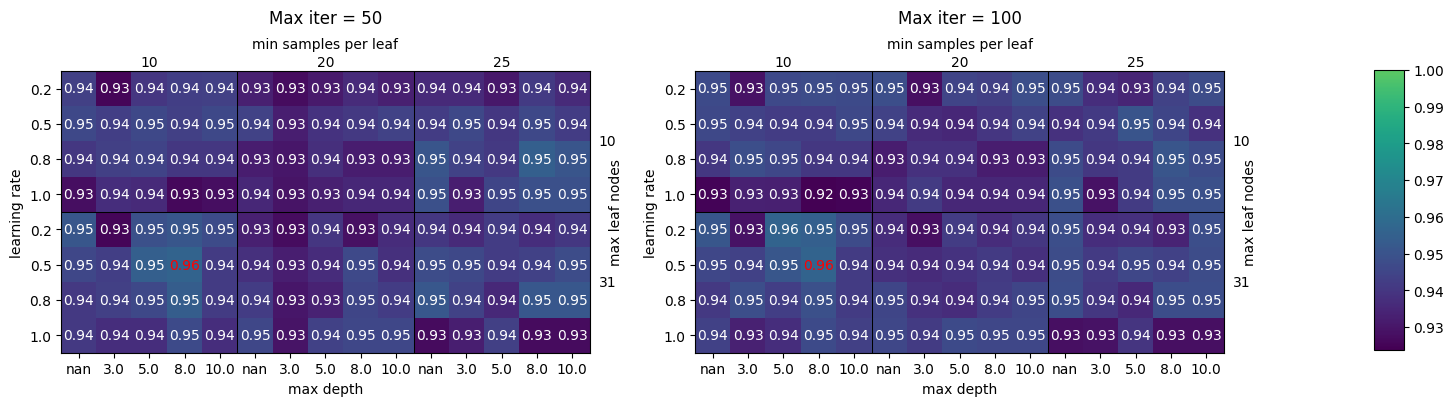

MIGLIORI IPERPARAMETRI


,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
87,0.5,8,50,31,10,1.0,0.956381,0.141074


CON PCA


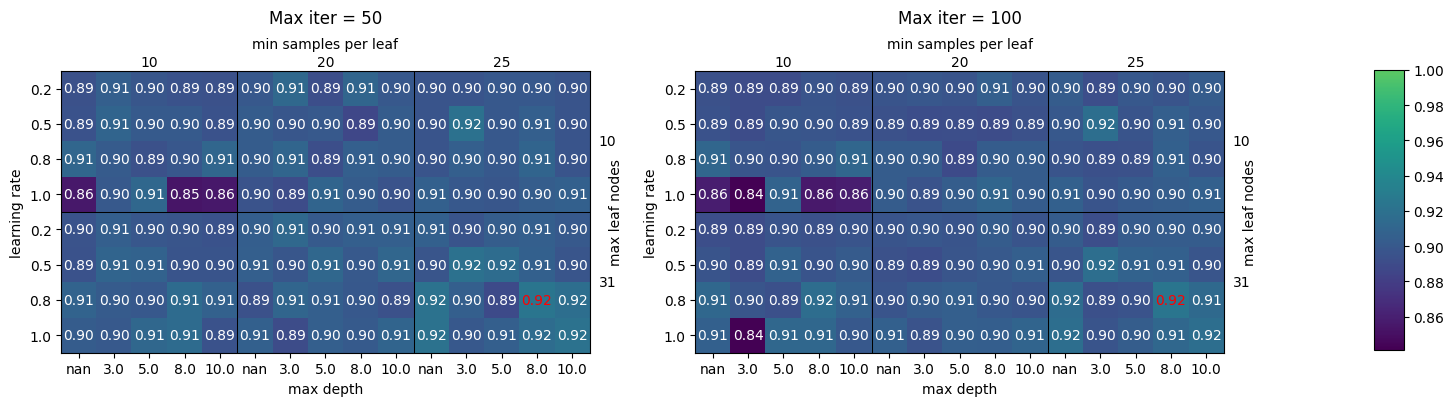

MIGLIORI IPERPARAMETRI


,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
149,0.8,8,50,31,25,1.0,0.923365,0.11637


CLASSICO - OVERSAMPLING


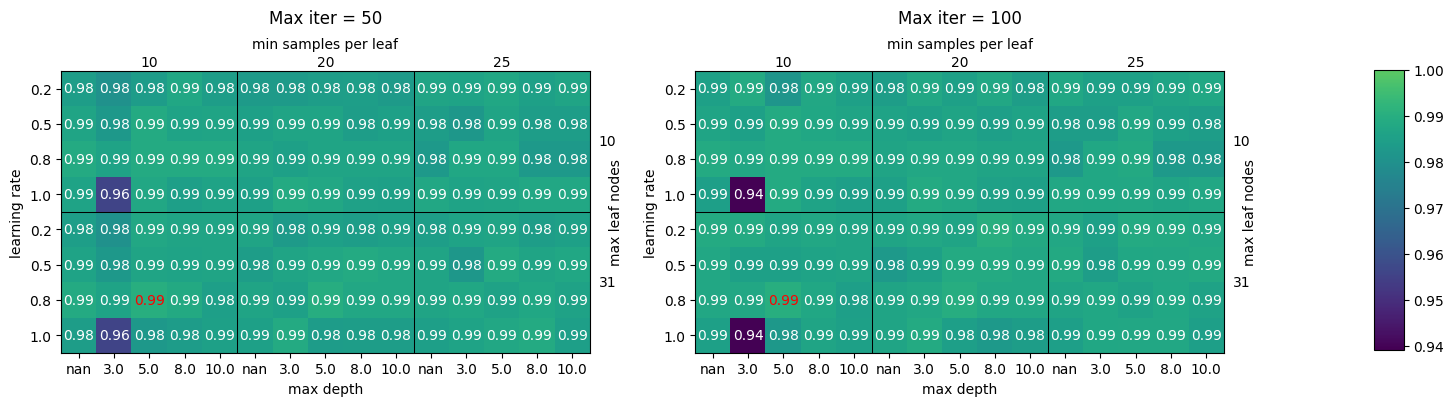

MIGLIORI IPERPARAMETRI


,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
135,0.8,5,50,31,10,1.0,0.989923,0.110982


NO CORRELATED FEATURE - OVERSAMPLING


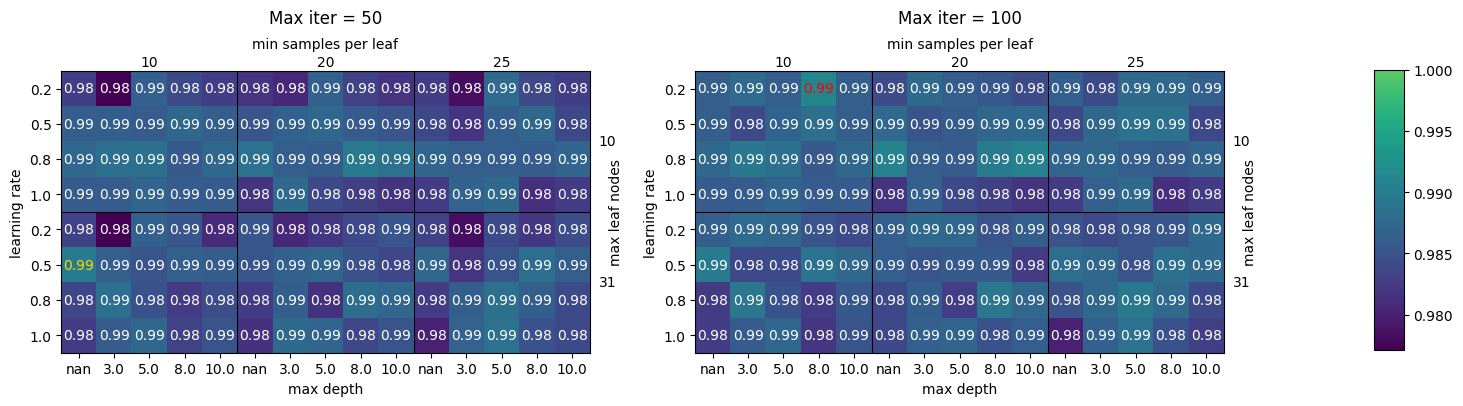

MIGLIORI IPERPARAMETRI


,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
30,0.2,8,100,10,10,1.0,0.991083,0.274488


NO SMOKING - OVERSAMPLING


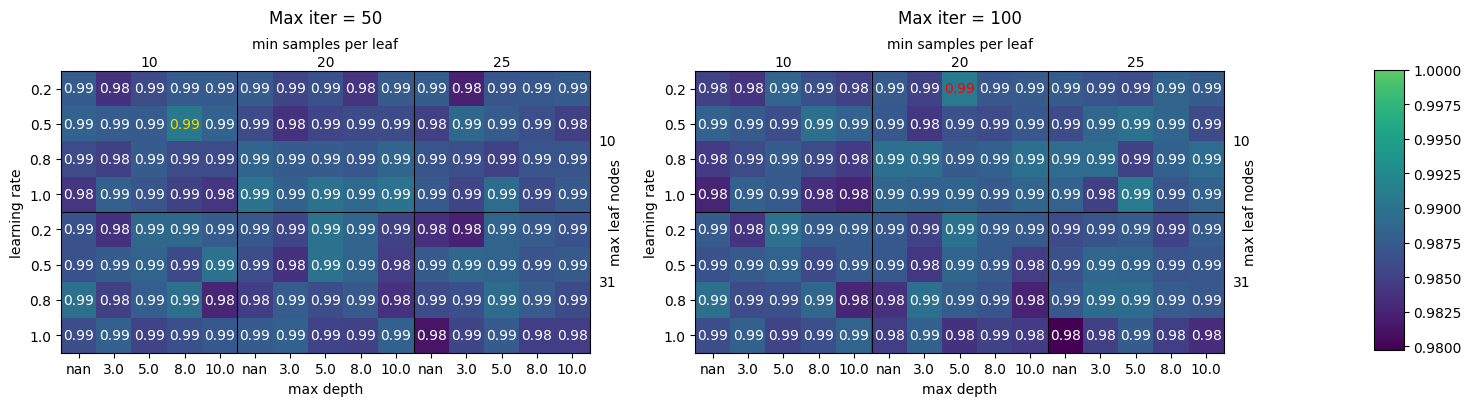

MIGLIORI IPERPARAMETRI


,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
19,0.2,5,100,10,20,1.0,0.990907,0.201053


CON PCA - OVERSAMPLING


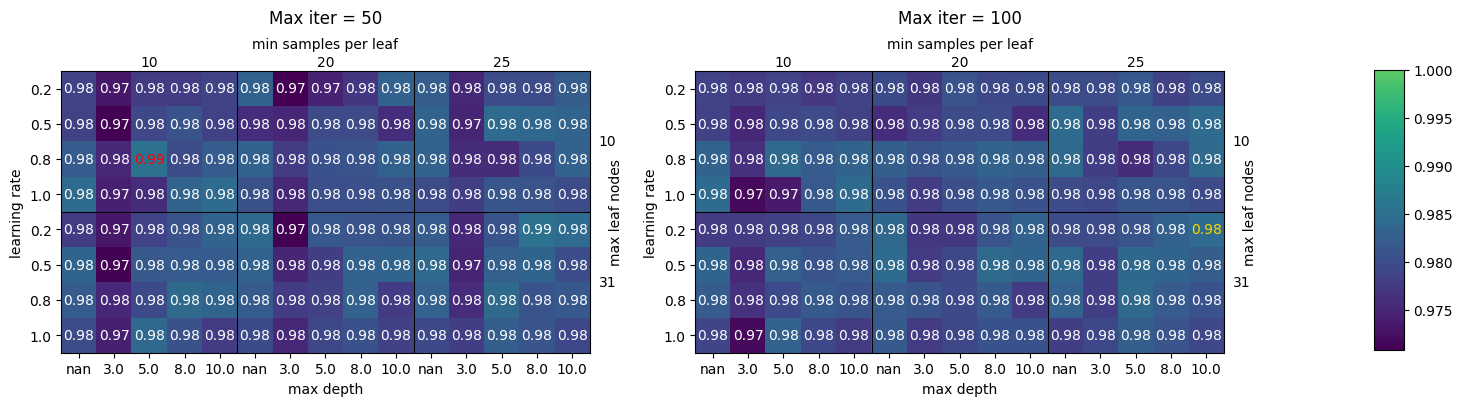

MIGLIORI IPERPARAMETRI


,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
132,0.8,5,50,10,10,1.0,0.985442,0.090151


In [50]:
scoreInterest='mean_test_score'
print('CLASSICO')
bestModel = heatMapGridSearch(results1, GRID, scoreInterest)
print('NO CORRELATED FEATURE')
bestModel_noFeat = heatMapGridSearch(results1_noFeat, GRID, scoreInterest)
print('NO SMOKING')
bestModel_noSmok = heatMapGridSearch(results1_noSmok, GRID, scoreInterest)
print('CON PCA')
bestModel_PCA = heatMapGridSearch(results1_PCA, GRID, scoreInterest)
print('CLASSICO - OVERSAMPLING')
bestModel_os = heatMapGridSearch(results1_os, GRID, scoreInterest)
print('NO CORRELATED FEATURE - OVERSAMPLING')
bestModel_noFeat_os = heatMapGridSearch(results1_noFeat_os, GRID, scoreInterest)
print('NO SMOKING - OVERSAMPLING')
bestModel_noSmok_os = heatMapGridSearch(results1_noSmok_os, GRID, scoreInterest)
print('CON PCA - OVERSAMPLING')
bestModel_PCA_os = heatMapGridSearch(results1_PCA_os, GRID, scoreInterest)

### Raffinamento modello migliore

#### Dati originali - Oversampling

In [51]:
#Definizione dei nuovi valori degli iperparametri
GRID = {
    'learning_rate': [0.1, 0.2, 0.4, 0.6],
    'max_iter': [75, 100],
    'max_leaf_nodes': [10, 31],
    'min_samples_leaf': [15, 20, 25],
    'max_depth': [3, 5, 8, 10, None]
}

In [52]:
#Dichiarazione della svm
hgb2_os = HistGradientBoostingClassifier(random_state=random_seed)

#Dichiarazione delle GridSearch
hgb2_gs_os = GridSearchCV(estimator=hgb2_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
hgb2_gs_os.fit(df_train_scal_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results2_os = pd.DataFrame(hgb2_gs_os.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


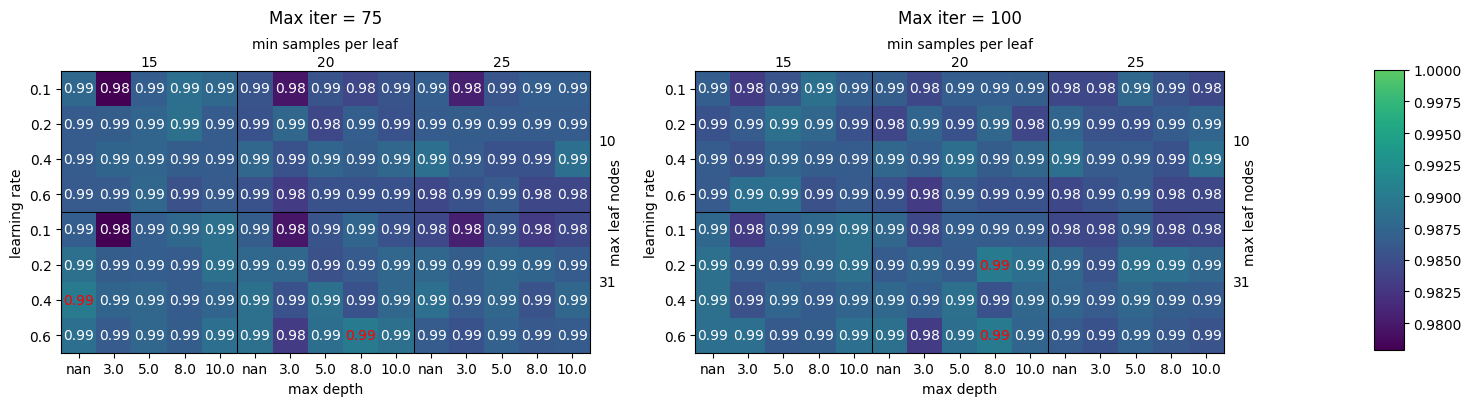

MIGLIORI IPERPARAMETRI


,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
94,0.2,8,100,31,20,1.0,0.989898,0.400516


In [53]:
#Stampa delle heat map delle grid search
scoreInterest='mean_test_score'
bestModel2_os = heatMapGridSearch(results2_os, GRID, scoreInterest)

#### No feature correlata - Oversampling	

In [54]:
#Definizione dei nuovi valori degli iperparametri
GRID = {
    'learning_rate': [0.01, 0.1, 0.2, 0.4],
    'max_iter': [75, 100],
    'max_leaf_nodes': [10, 31],
    'min_samples_leaf': [8, 10, 20],
    'max_depth': [2, 3, 5, 8, None]
}

In [55]:
#Dichiarazione della svm
hgb2_noFeat_os = HistGradientBoostingClassifier(random_state=random_seed)

#Dichiarazione delle GridSearch
hgb2_noFeat_gs_os = GridSearchCV(estimator=hgb2_noFeat_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
hgb2_noFeat_gs_os.fit(df_train_noFeat_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results2_noFeat_os = pd.DataFrame(hgb2_noFeat_gs_os.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


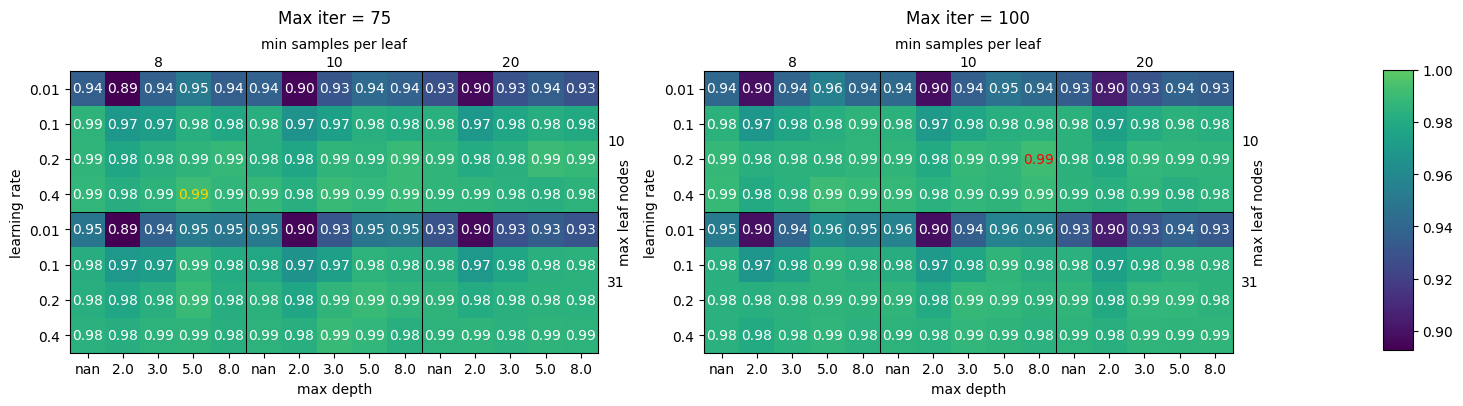

MIGLIORI IPERPARAMETRI


,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
163,0.2,8,100,10,10,1.0,0.991083,0.219866


In [56]:
#Stampa delle heat map delle grid search
scoreInterest='mean_test_score'
bestModel2_noFeat_os = heatMapGridSearch(results2_noFeat_os, GRID, scoreInterest)

### Feature augmentation

#### Grid Search e train

In [58]:
#Definizione degli iperparametri e della griglia
GRID = {
    'learning_rate': [0.2, 0.5, 0.8, 1],
    'max_iter': [50,100],
    'max_leaf_nodes': [10, 31],
    'min_samples_leaf': [10, 20, 25],
    'max_depth': [3, 5, 8, 10, None]
}

##### Classico - Oversampling, Augmentation

In [59]:
#Dichiarazione della svm
hgb1_os_fa = HistGradientBoostingClassifier(random_state=random_seed)

#Dichiarazione delle GridSearch
hgb1_gs_os_fa = GridSearchCV(estimator=hgb1_os_fa,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
hgb1_gs_os_fa.fit(df_train_scal_os_fa, y_train_os_fa)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_os_fa = pd.DataFrame(hgb1_gs_os_fa.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


##### No correlation - Oversampling, Augmentation

In [60]:
#Dichiarazione della svm
hgb1_noFeat_os_fa = HistGradientBoostingClassifier(random_state=random_seed)

#Dichiarazione delle GridSearch
hgb1_noFeat_gs_os_fa = GridSearchCV(estimator=hgb1_noFeat_os_fa,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
hgb1_noFeat_gs_os_fa.fit(df_train_noFeat_os_fa, y_train_os_fa)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noFeat_os_fa = pd.DataFrame(hgb1_noFeat_gs_os_fa.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


##### No smoking - Oversampling, Augmentation

In [61]:
#Dichiarazione della svm
hgb1_noSmok_os_fa = HistGradientBoostingClassifier(random_state=random_seed)

#Dichiarazione delle GridSearch
hgb1_noSmok_gs_os_fa = GridSearchCV(estimator=hgb1_noSmok_os_fa,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
hgb1_noSmok_gs_os_fa.fit(df_train_noSmok_os_fa, y_train_os_fa)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noSmok_os_fa = pd.DataFrame(hgb1_noSmok_gs_os_fa.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


##### PCA - Oversampling, Augmentation

In [62]:
#Dichiarazione della svm
hgb1_PCA_os_fa = HistGradientBoostingClassifier(random_state=random_seed)

#Dichiarazione delle GridSearch
hgb1_PCA_gs_os_fa = GridSearchCV(estimator=hgb1_PCA_os_fa,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
hgb1_PCA_gs_os_fa.fit(df_train_PCA_os_fa, y_train_os_fa)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_PCA_os_fa = pd.DataFrame(hgb1_PCA_gs_os_fa.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


#### Visualizzazione

Stampa delle heat map delle grid search

CLASSICO - OVERSAMPLING, AUGMENTATION


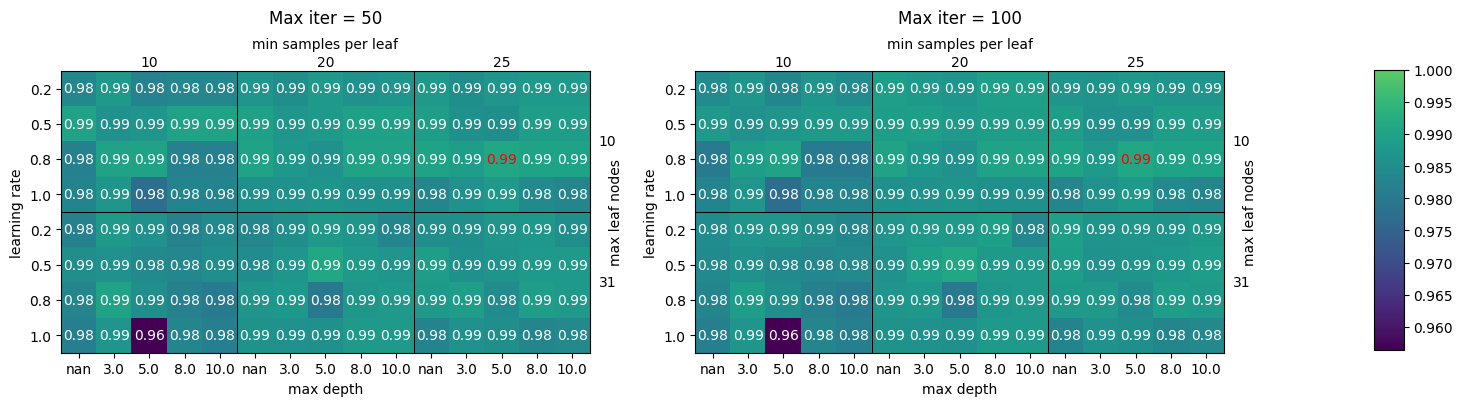

MIGLIORI IPERPARAMETRI


,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
134,0.8,5,50,10,25,1.0,0.991085,0.317017


NO CORRELATED FEATURE - OVERSAMPLING, AUGMENTATION


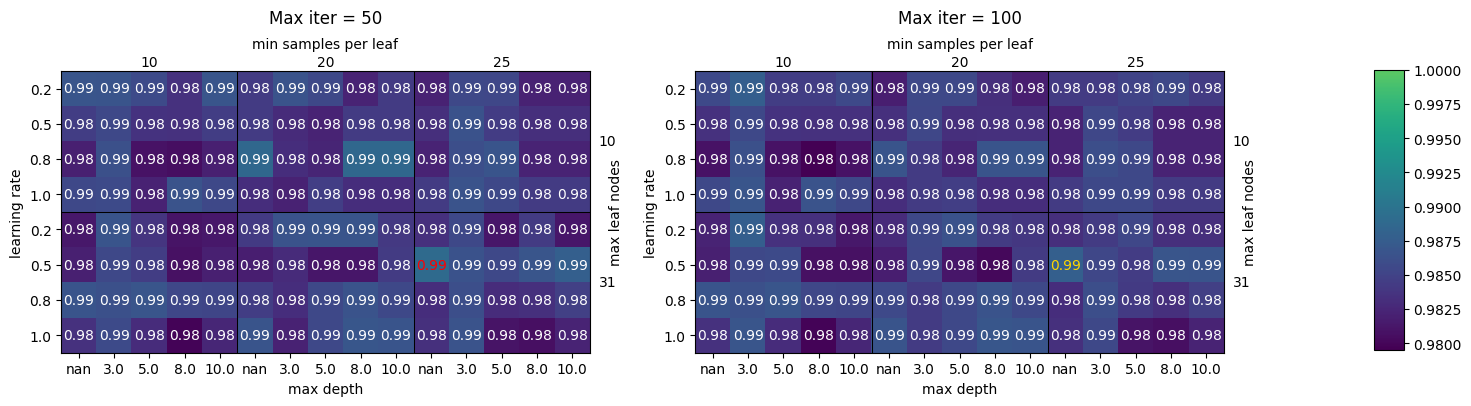

MIGLIORI IPERPARAMETRI


,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
113,0.5,None,50,31,25,1.0,0.988886,0.470493


NO SMOKING - OVERSAMPLING, AUGMENTATION


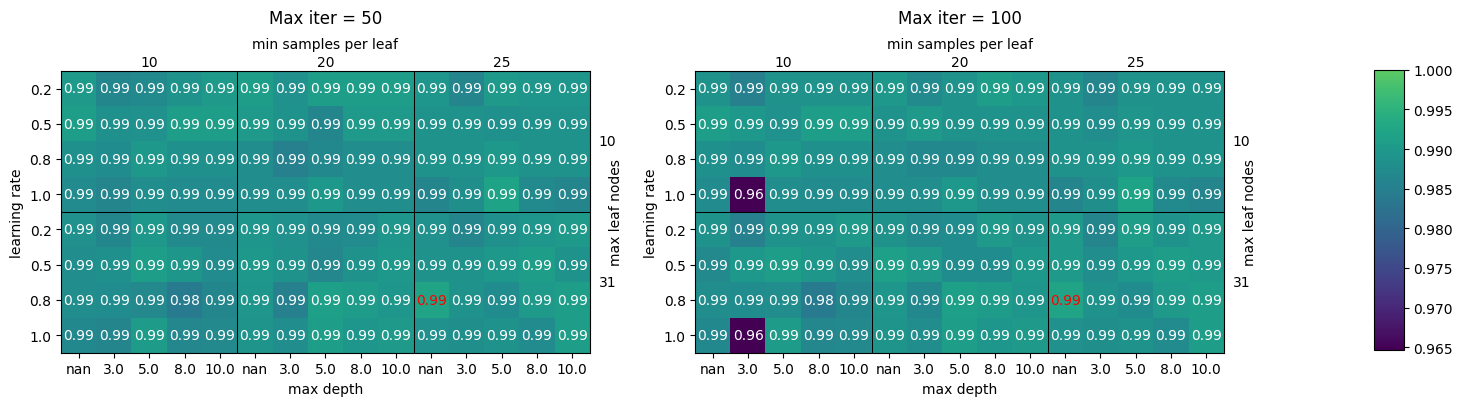

MIGLIORI IPERPARAMETRI


,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
173,0.8,None,50,31,25,1.0,0.992199,0.262641


CON PCA - OVERSAMPLING, AUGMENTATION


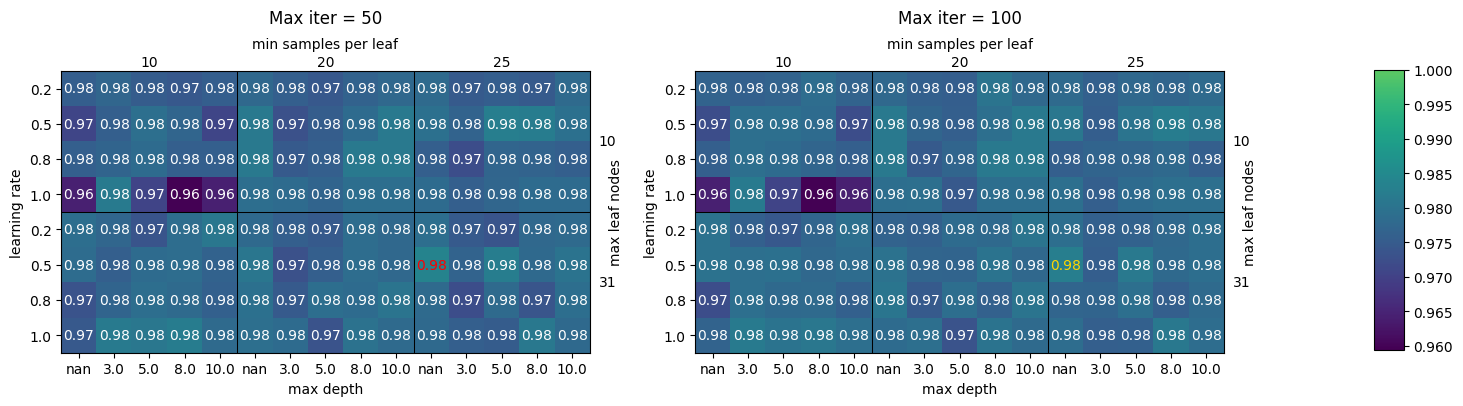

MIGLIORI IPERPARAMETRI


,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
113,0.5,None,50,31,25,1.0,0.983623,0.310253


In [63]:
scoreInterest='mean_test_score'
print('CLASSICO - OVERSAMPLING, AUGMENTATION')
bestModel_os_fa = heatMapGridSearch(results1_os_fa, GRID, scoreInterest)
print('NO CORRELATED FEATURE - OVERSAMPLING, AUGMENTATION')
bestModel_noFeat_os_fa = heatMapGridSearch(results1_noFeat_os_fa, GRID, scoreInterest)
print('NO SMOKING - OVERSAMPLING, AUGMENTATION')
bestModel_noSmok_os_fa = heatMapGridSearch(results1_noSmok_os_fa, GRID, scoreInterest)
print('CON PCA - OVERSAMPLING, AUGMENTATION')
bestModel_PCA_os_fa = heatMapGridSearch(results1_PCA_os_fa, GRID, scoreInterest)

#### Raffinamento modello migliore

##### Dati originali - Oversampling, Augmentation

In [64]:
#Definizione dei nuovi valori degli iperparametri
GRID = {
    'learning_rate': [0.2, 0.5, 0.8, 1.0],
    'max_iter': [75, 100],
    'max_leaf_nodes': [20, 25],
    'min_samples_leaf': [22, 25, 30],
    'max_depth': [5, 8, 10, 15, None]
}

In [65]:
#Dichiarazione della svm
hgb2_os_fa = HistGradientBoostingClassifier(random_state=random_seed)

#Dichiarazione delle GridSearch
hgb2_gs_os_fa = GridSearchCV(estimator=hgb2_os_fa,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
hgb2_gs_os_fa.fit(df_train_scal_os_fa, y_train_os_fa)

# Mostriamo i risultati della Gridsearch con una tabella:
results2_os_fa = pd.DataFrame(hgb2_gs_os_fa.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


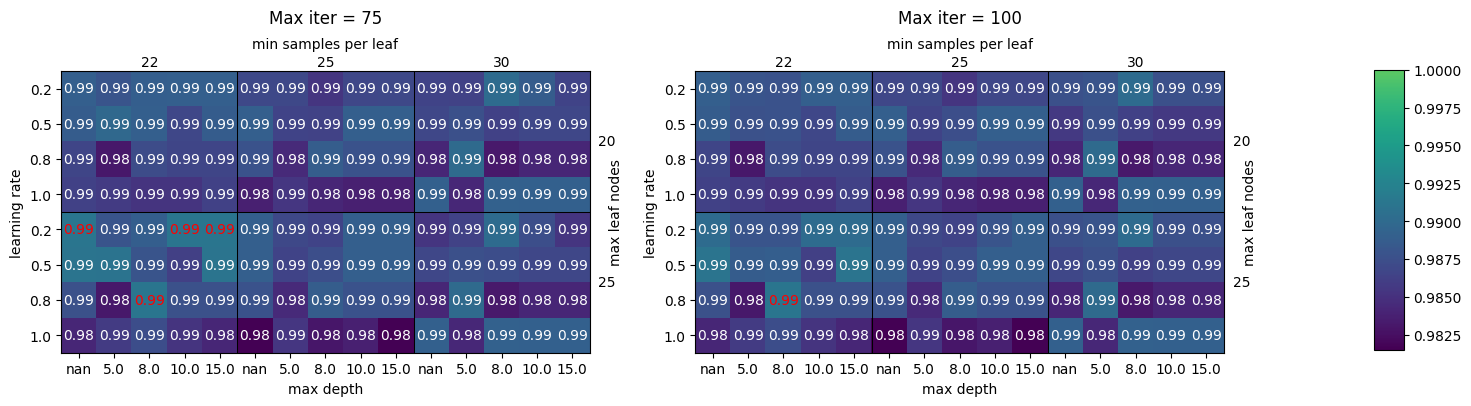

MIGLIORI IPERPARAMETRI


,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
27,0.2,10,75,25,22,1.0,0.99103,1.186871


In [66]:
#Stampa delle heat map delle grid search
scoreInterest='mean_test_score'
bestModel2_os_fa = heatMapGridSearch(results2_os_fa, GRID, scoreInterest)

### Test del modello migliore

#### Identificazione modello migliore in validation

In [67]:
bestModels_df = pd.DataFrame(np.vstack((bestModel,bestModel_noFeat,bestModel_noSmok,bestModel_PCA, bestModel_os, bestModel_noFeat_os, bestModel_noSmok_os, bestModel_PCA_os, bestModel2_os, bestModel2_noFeat_os)), index=['Dati originali', 'No feature correlata','No smoking', 'PCA','Dati originali - Oversampling', 'No feature correlata - Oversampling','No smoking - Oversampling', 'PCA - Oversampling','Dati originali - Oversampling (raffinamento)', 'No feature correlata - Oversampling (raffinamento)'], columns=bestModel.index)
display(bestModels_df[['mean_test_score', 'mean_fit_time']].rename(columns={'mean_test_score':'f1 score medio su validation', 'mean_fit_time':'Tempo medio addestramento'}))

,f1 score medio su validation,Tempo medio addestramento
Dati originali,0.964497,0.064288
No feature correlata,0.963599,0.073591
No smoking,0.956381,0.141074
PCA,0.923365,0.11637
Dati originali - Oversampling,0.989923,0.110982
No feature correlata - Oversampling,0.991083,0.274488
No smoking - Oversampling,0.990907,0.201053
PCA - Oversampling,0.985442,0.090151
Dati originali - Oversampling (raffinamento),0.989898,0.400516
No feature correlata - Oversampling (raffinamento),0.991083,0.219866


In [68]:
bestModels_df = pd.DataFrame(np.vstack((bestModel_os_fa, bestModel_noFeat_os_fa, bestModel_noSmok_os_fa, bestModel_PCA_os_fa, bestModel2_os_fa)), index=['Dati originali - Oversampling, Augmentation', 'No feature correlata - Oversampling, Augmentation','No smoking - Oversampling, Augmentation', 'PCA - Oversampling, Augmentation','Dati originali - Oversampling, Augmentation (raffinamento)'], columns=bestModel_os_fa.index)
display(bestModels_df[['mean_test_score', 'mean_fit_time']].rename(columns={'mean_test_score':'f1 score medio su validation', 'mean_fit_time':'Tempo medio addestramento'}))

,f1 score medio su validation,Tempo medio addestramento
"Dati originali - Oversampling, Augmentation",0.991085,0.317017
"No feature correlata - Oversampling, Augmentation",0.988886,0.470493
"No smoking - Oversampling, Augmentation",0.992199,0.262641
"PCA - Oversampling, Augmentation",0.983623,0.310253
"Dati originali - Oversampling, Augmentation (raffinamento)",0.99103,1.186871


In [69]:
#Classico
besthgb = HistGradientBoostingClassifier(random_state=random_seed, max_depth=bestModel['param_max_depth'], learning_rate=bestModel['param_learning_rate'], min_samples_leaf=bestModel['param_min_samples_leaf'], max_leaf_nodes=bestModel['param_max_leaf_nodes'], max_iter=bestModel['param_max_iter'])
start=time.time()
besthgb.fit(df_train_scal,y_train)
stop=time.time()
besthgb_fit_time = stop-start

#No correlated feature
besthgb_noFeat = HistGradientBoostingClassifier(random_state=random_seed, max_depth=bestModel_noFeat['param_max_depth'], learning_rate=bestModel_noFeat['param_learning_rate'], min_samples_leaf=bestModel_noFeat['param_min_samples_leaf'], max_leaf_nodes=bestModel_noFeat['param_max_leaf_nodes'], max_iter=bestModel_noFeat['param_max_iter'])
start=time.time()
besthgb_noFeat.fit(df_train_noFeat,y_train)
stop=time.time()
besthgb_noFeat_fit_time = stop-start

#No smoking
besthgb_noSmok = HistGradientBoostingClassifier(random_state=random_seed, max_depth=bestModel_noSmok['param_max_depth'], learning_rate=bestModel_noSmok['param_learning_rate'], min_samples_leaf=bestModel_noSmok['param_min_samples_leaf'], max_leaf_nodes=bestModel_noSmok['param_max_leaf_nodes'], max_iter=bestModel_noSmok['param_max_iter'])
start=time.time()
besthgb_noSmok.fit(df_train_noSmok,y_train)
stop=time.time()
besthgb_noSmok_fit_time = stop-start

#PCA
besthgb_PCA = HistGradientBoostingClassifier(random_state=random_seed, max_depth=bestModel_PCA['param_max_depth'], learning_rate=bestModel_PCA['param_learning_rate'], min_samples_leaf=bestModel_PCA['param_min_samples_leaf'], max_leaf_nodes=bestModel_PCA['param_max_leaf_nodes'], max_iter=bestModel_PCA['param_max_iter'])
start=time.time()
besthgb_PCA.fit(df_train_PCA,y_train)
stop=time.time()
besthgb_PCA_fit_time = stop-start

#Classico - Oversampling
besthgb_os = HistGradientBoostingClassifier(random_state=random_seed, max_depth=bestModel_os['param_max_depth'], learning_rate=bestModel_os['param_learning_rate'], min_samples_leaf=bestModel_os['param_min_samples_leaf'], max_leaf_nodes=bestModel_os['param_max_leaf_nodes'], max_iter=bestModel_os['param_max_iter'])
start=time.time()
besthgb_os.fit(df_train_scal_os,y_train_os)
stop=time.time()
besthgb_os_fit_time = stop-start

#No correlated feature - Oversampling
besthgb_noFeat_os = HistGradientBoostingClassifier(random_state=random_seed, max_depth=bestModel_noFeat_os['param_max_depth'], learning_rate=bestModel_noFeat_os['param_learning_rate'], min_samples_leaf=bestModel_noFeat_os['param_min_samples_leaf'], max_leaf_nodes=bestModel_noFeat_os['param_max_leaf_nodes'], max_iter=bestModel_noFeat_os['param_max_iter'])
start=time.time()
besthgb_noFeat_os.fit(df_train_noFeat_os,y_train_os)
stop=time.time()
besthgb_noFeat_os_fit_time = stop-start

#No smoking - Oversampling
besthgb_noSmok_os = HistGradientBoostingClassifier(random_state=random_seed, max_depth=bestModel_noSmok_os['param_max_depth'], learning_rate=bestModel_noSmok_os['param_learning_rate'], min_samples_leaf=bestModel_noSmok_os['param_min_samples_leaf'], max_leaf_nodes=bestModel_noSmok_os['param_max_leaf_nodes'], max_iter=bestModel_noSmok_os['param_max_iter'])
start=time.time()
besthgb_noSmok_os.fit(df_train_noSmok_os,y_train_os)
stop=time.time()
besthgb_noSmok_os_fit_time = stop-start

#PCA - Oversampling
besthgb_PCA_os = HistGradientBoostingClassifier(random_state=random_seed, max_depth=bestModel_PCA_os['param_max_depth'], learning_rate=bestModel_PCA_os['param_learning_rate'], min_samples_leaf=bestModel_PCA_os['param_min_samples_leaf'], max_leaf_nodes=bestModel_PCA_os['param_max_leaf_nodes'], max_iter=bestModel_PCA_os['param_max_iter'])
start=time.time()
besthgb_PCA_os.fit(df_train_PCA_os,y_train_os)
stop=time.time()
besthgb_PCA_os_fit_time = stop-start

#Classico - Oversampling (Raffinamento)
besthgb2_os = HistGradientBoostingClassifier(random_state=random_seed, max_depth=bestModel2_os['param_max_depth'], learning_rate=bestModel2_os['param_learning_rate'], min_samples_leaf=bestModel2_os['param_min_samples_leaf'], max_leaf_nodes=bestModel2_os['param_max_leaf_nodes'], max_iter=bestModel2_os['param_max_iter'])
start=time.time()
besthgb2_os.fit(df_train_scal_os,y_train_os)
stop=time.time()
besthgb2_os_fit_time = stop-start

In [70]:
#Classico - Oversampling, Augmentation
besthgb_os_fa = HistGradientBoostingClassifier(random_state=random_seed, max_depth=bestModel_os_fa['param_max_depth'], learning_rate=bestModel_os_fa['param_learning_rate'], min_samples_leaf=bestModel_os_fa['param_min_samples_leaf'], max_leaf_nodes=bestModel_os_fa['param_max_leaf_nodes'], max_iter=bestModel_os_fa['param_max_iter'])
start=time.time()
besthgb_os_fa.fit(df_train_scal_os_fa,y_train_os_fa)
stop=time.time()
besthgb_os_fa_fit_time = stop-start

#No correlated feature - Oversampling, Augmentation
besthgb_noFeat_os_fa = HistGradientBoostingClassifier(random_state=random_seed, max_depth=bestModel_noFeat_os_fa['param_max_depth'], learning_rate=bestModel_noFeat_os_fa['param_learning_rate'], min_samples_leaf=bestModel_noFeat_os_fa['param_min_samples_leaf'], max_leaf_nodes=bestModel_noFeat_os_fa['param_max_leaf_nodes'], max_iter=bestModel_noFeat_os_fa['param_max_iter'])
start=time.time()
besthgb_noFeat_os_fa.fit(df_train_noFeat_os_fa,y_train_os_fa)
stop=time.time()
besthgb_noFeat_os_fa_fit_time = stop-start

#No smoking - Oversampling, Augmentation
besthgb_noSmok_os_fa = HistGradientBoostingClassifier(random_state=random_seed, max_depth=bestModel_noSmok_os_fa['param_max_depth'], learning_rate=bestModel_noSmok_os_fa['param_learning_rate'], min_samples_leaf=bestModel_noSmok_os_fa['param_min_samples_leaf'], max_leaf_nodes=bestModel_noSmok_os_fa['param_max_leaf_nodes'], max_iter=bestModel_noSmok_os_fa['param_max_iter'])
start=time.time()
besthgb_noSmok_os_fa.fit(df_train_noSmok_os_fa,y_train_os_fa)
stop=time.time()
besthgb_noSmok_fa_os_fit_time = stop-start

#PCA - Oversampling, Augmentation
besthgb_PCA_os_fa = HistGradientBoostingClassifier(random_state=random_seed, max_depth=bestModel_PCA_os_fa['param_max_depth'], learning_rate=bestModel_PCA_os_fa['param_learning_rate'], min_samples_leaf=bestModel_PCA_os_fa['param_min_samples_leaf'], max_leaf_nodes=bestModel_PCA_os_fa['param_max_leaf_nodes'], max_iter=bestModel_PCA_os_fa['param_max_iter'])
start=time.time()
besthgb_PCA_os_fa.fit(df_train_PCA_os_fa,y_train_os_fa)
stop=time.time()
besthgb_PCA_os_fa_fit_time = stop-start

#Classico - Oversampling, Augmentation (Raffinamento)
besthgb2_os_fa = HistGradientBoostingClassifier(random_state=random_seed, max_depth=bestModel2_os_fa['param_max_depth'], learning_rate=bestModel2_os_fa['param_learning_rate'], min_samples_leaf=bestModel2_os_fa['param_min_samples_leaf'], max_leaf_nodes=bestModel2_os_fa['param_max_leaf_nodes'], max_iter=bestModel2_os_fa['param_max_iter'])
start=time.time()
besthgb2_os_fa.fit(df_train_scal_os_fa,y_train_os_fa)
stop=time.time()
besthgb2_os_fa_fit_time = stop-start

Vediamo ora come si comportano i modelli quando vengono applicati ai dati del test set.

In [71]:
# DATI ORIGINALI
perf_trainval_hgb,cmat_trainval_hgb,hgb_predict_time_trainval = performances(besthgb,df_train_scal,y_train,'training')
perf_hgb,cmat_hgb,hgb_predict_time = performances(besthgb,df_test_scal,y_test,'test')
metrics_scal = pd.concat([perf_trainval_hgb,perf_hgb])

# NO FEATURE CORRELATA
perf_trainval_hgb,cmat_trainval_hgb,hgb_predict_time_trainval = performances(besthgb_noFeat,df_train_noFeat,y_train,'training')
perf_hgb,cmat_hgb_noFeat,hgb_predict_time = performances(besthgb_noFeat,df_test_noFeat,y_test,'test')
metrics_noFeat = pd.concat([perf_trainval_hgb,perf_hgb])

# NO SMOKING
perf_trainval_hgb,cmat_trainval_hgb,hgb_predict_time_trainval = performances(besthgb_noSmok,df_train_noSmok,y_train,'training')
perf_hgb,cmat_hgb_noSmok,hgb_predict_time = performances(besthgb_noSmok,df_test_noSmok,y_test,'test')
metrics_noSmock = pd.concat([perf_trainval_hgb,perf_hgb])

# CON PCA
perf_trainval_hgb,cmat_trainval_hgb,hgb_predict_time_trainval = performances(besthgb_PCA,df_train_PCA,y_train,'training')
perf_hgb,cmat_hgb_PCA,hgb_predict_time = performances(besthgb_PCA,df_test_PCA,y_test,'test')
metrics_PCA = pd.concat([perf_trainval_hgb,perf_hgb])

comparison_normal = pd.concat([metrics_scal, metrics_noFeat,metrics_noSmock,metrics_PCA], axis=0, keys=['Dati originali', 'No feature correlata','No smoking','Con PCA'])

In [72]:
#DATI ORIGINALI - OVERSAMPLING
perf_trainval_hgb,cmat_trainval_hgb,hgb_predict_time_trainval = performances(besthgb_os,df_train_scal_os,y_train_os,'training')
perf_hgb,cmat_hgb_os,hgb_predict_time = performances(besthgb_os,df_test_scal_os,y_test_os,'test')
metrics_scal_os = pd.concat([perf_trainval_hgb,perf_hgb])

# NO FEATURE CORRELATA - OVERSAMPLING
perf_trainval_hgb,cmat_trainval_hgb,hgb_predict_time_trainval = performances(besthgb_noFeat_os,df_train_noFeat_os,y_train_os,'training')
perf_hgb,cmat_hgb_noFeat_os,hgb_predict_time = performances(besthgb_noFeat_os,df_test_noFeat_os,y_test_os,'test')
metrics_noFeat_os = pd.concat([perf_trainval_hgb,perf_hgb])

# NO SMOKING - OVERSAMPLING
perf_trainval_hgb,cmat_trainval_hgb,hgb_predict_time_trainval = performances(besthgb_noSmok_os,df_train_noSmok_os,y_train_os,'training')
perf_hgb,cmat_hgb_noSmok_os,hgb_predict_time = performances(besthgb_noSmok_os,df_test_noSmok_os,y_test_os,'test')
metrics_noSmock_os = pd.concat([perf_trainval_hgb,perf_hgb])

# CON PCA - OVERSAMPLING
perf_trainval_hgb,cmat_trainval_hgb,hgb_predict_time_trainval = performances(besthgb_PCA_os,df_train_PCA_os,y_train_os,'training')
perf_hgb,cmat_hgb_PCA_os,hgb_predict_time = performances(besthgb_PCA_os,df_test_PCA_os,y_test_os,'test')
metrics_PCA_os = pd.concat([perf_trainval_hgb,perf_hgb])

comparison_os = pd.concat([metrics_scal_os, metrics_noFeat_os,metrics_noSmock_os,metrics_PCA_os], axis=0, keys=['Dati originali', 'No feature correlata','No smoking','Con PCA'])

In [73]:
#DATI ORIGINALI - OVERSAMPLING (RAFFINAMENTO)
perf_trainval_hgb,cmat_trainval_hgb,hgb_predict_time_trainval = performances(besthgb2_os,df_train_scal_os,y_train_os,'training')
perf_hgb,cmat_hgb2_os,hgb_predict_time = performances(besthgb2_os,df_test_scal_os,y_test_os,'test')
metrics2_scal_os = pd.concat([perf_trainval_hgb,perf_hgb])

In [ ]:
#DATI ORIGINALI - OVERSAMPLING, AUGMENTATION
perf_trainval_hgb,cmat_trainval_hgb,hgb_predict_time_trainval = performances(besthgb_os_fa,df_train_scal_os_fa,y_train_os_fa,'training')
perf_hgb,cmat_hgb_os,hgb_predict_time = performances(besthgb_os_fa,df_test_scal_os_fa,y_test_os_fa,'test')
metrics_scal_os_fa = pd.concat([perf_trainval_hgb,perf_hgb])

# NO FEATURE CORRELATA - OVERSAMPLING, AUGMENTATION
perf_trainval_hgb,cmat_trainval_hgb,hgb_predict_time_trainval = performances(besthgb_noFeat_os_fa,df_train_noFeat_os_fa,y_train_os_fa,'training')
perf_hgb,cmat_hgb_noFeat_os,hgb_predict_time = performances(besthgb_noFeat_os_fa,df_test_noFeat_os_fa,y_test_os_fa,'test')
metrics_noFeat_os_fa = pd.concat([perf_trainval_hgb,perf_hgb])

# NO SMOKING - OVERSAMPLING, AUGMENTATION
perf_trainval_hgb,cmat_trainval_hgb,hgb_predict_time_trainval = performances(besthgb_noSmok_os_fa,df_train_noSmok_os_fa,y_train_os_fa,'training')
perf_hgb,cmat_hgb_noSmok_os,hgb_predict_time = performances(besthgb_noSmok_os_fa,df_test_noSmok_os_fa,y_test_os_fa,'test')
metrics_noSmock_os_fa = pd.concat([perf_trainval_hgb,perf_hgb])

# CON PCA - OVERSAMPLING, AUGMENTATION
perf_trainval_hgb,cmat_trainval_hgb,hgb_predict_time_trainval = performances(besthgb_PCA_os_fa,df_train_PCA_os_fa,y_train_os_fa,'training')
perf_hgb,cmat_hgb_PCA_os,hgb_predict_time = performances(besthgb_PCA_os_fa,df_test_PCA_os_fa,y_test_os_fa,'test')
metrics_PCA_os_fa = pd.concat([perf_trainval_hgb,perf_hgb])

comparison_os_fa = pd.concat([metrics_scal_os_fa, metrics_noFeat_os_fa,metrics_noSmock_os_fa,metrics_PCA_os_fa], axis=0, keys=['Dati originali', 'No feature correlata','No smoking','Con PCA'])

In [ ]:
#DATI ORIGINALI - OVERSAMPLING, AUGMENTATION (RAFFINAMENTO)
perf_trainval_hgb,cmat_trainval_hgb,hgb_predict_time_trainval = performances(besthgb2_os_fa,df_train_scal_os_fa,y_train_os_fa,'training')
perf_hgb,cmat_hgb2_os,hgb_predict_time = performances(besthgb2_os_fa,df_test_scal_os_fa,y_test_os_fa,'test')
metrics2_scal_os_fa = pd.concat([perf_trainval_hgb,perf_hgb])

In [ ]:
comparison = pd.concat([comparison_normal, comparison_os, comparison_os_fa], axis=1, keys=['Dataset originale', 'Oversampling', 'Oversampling, Augmentation'])
display(comparison)

Dataset originale                                \
                                       Accuracy Precision    Recall        F1   
Dati originali       training          1.000000  1.000000  1.000000  1.000000   
                     test              0.986395  0.972973  0.972973  0.972973   
No feature correlata training          1.000000  1.000000  1.000000  1.000000   
                     test              0.986395  0.972973  0.972973  0.972973   
No smoking           training          1.000000  1.000000  1.000000  1.000000   
                     test              0.986395  0.972973  0.972973  0.972973   
Con PCA              training          1.000000  1.000000  1.000000  1.000000   
                     test              0.952381  0.941176  0.864865  0.901408   

                              Oversampling                                
                                  Accuracy Precision    Recall        F1  
Dati originali       training     1.000000  1.000000  1.000000  1.000000  
                     test         0.986395  0.972973  0.972973  0.972973  
No feature correlata training     1.000000  1.000000  1.000000  1.000000  
                     test         0.986395  0.972973  0.972973  0.972973  
No smoking           training     1.000000  1.000000  1.000000  1.000000  
                     test         0.986395  0.972973  0.972973  0.972973  
Con PCA              training     1.000000  1.000000  1.000000  1.000000  
                     test         0.959184  0.878049  0.972973  0.923077

In [ ]:
comparison_raff = pd.concat([metrics_scal_os, metrics2_scal_os, metrics2_scal_os_fa], axis=0, keys=['Dati originali - Overs.', 'Dati originali - Overs. (raffinamento)', 'Dati originali - Overs., Augm. (raffinamento)'])
display(comparison_raff)

Accuracy  Precision  \
Dati originali - Overs.                training  1.000000   1.000000   
                                       test      0.986395   0.972973   
Dati originali - Overs. (raffinamento) training  1.000000   1.000000   
                                       test      0.986395   0.972973   

                                                   Recall        F1  
Dati originali - Overs.                training  1.000000  1.000000  
                                       test      0.972973  0.972973  
Dati originali - Overs. (raffinamento) training  1.000000  1.000000  
                                       test      0.972973  0.972973

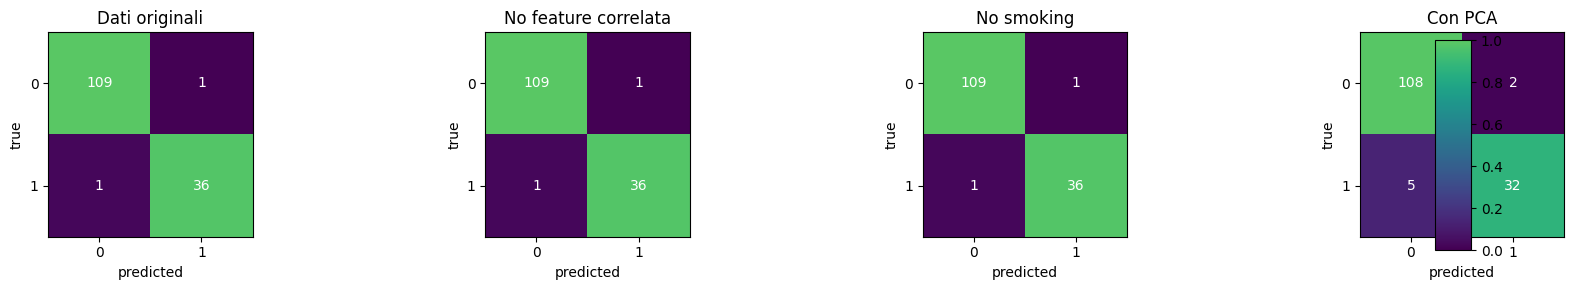

OVERSAMPLING


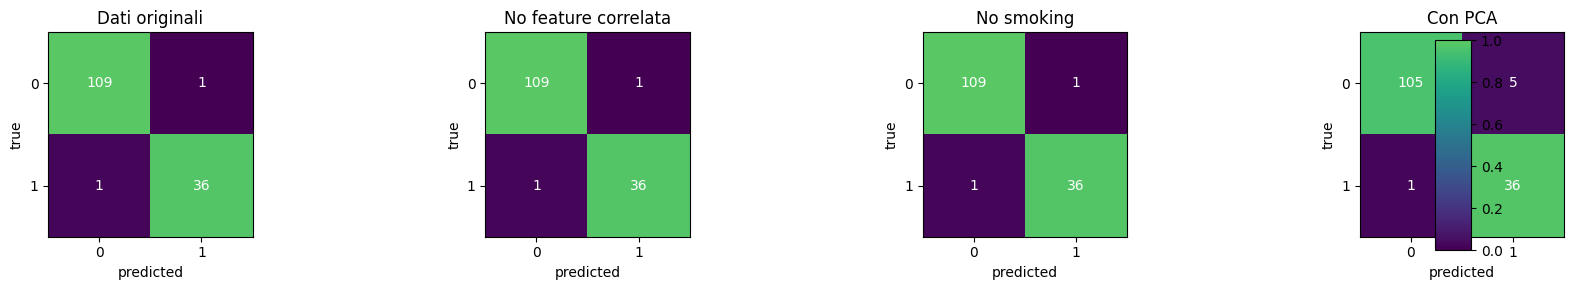

RAFFINAMENTO


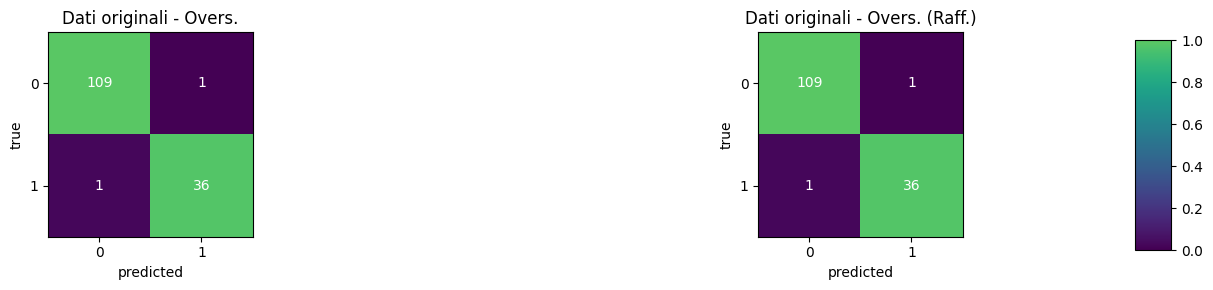

In [46]:
heatMapConstr([cmat_hgb,cmat_hgb_noFeat,cmat_hgb_noSmok,cmat_hgb_PCA], ['Dati originali', 'No feature correlata','No smoking','Con PCA'])
print('OVERSAMPLING')
heatMapConstr([cmat_hgb_os,cmat_hgb_noFeat_os,cmat_hgb_noSmok_os,cmat_hgb_PCA_os], ['Dati originali', 'No feature correlata','No smoking','Con PCA'])
print('RAFFINAMENTO')
heatMapConstr([cmat_hgb_os,cmat_hgb2_os], ['Dati originali - Overs.', 'Dati originali - Overs. (Raff.)'])
